# PET PROJECT: PERSONAL WELLBEING DATA MINING


In [64]:
#IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.ensemble import IsolationForest

In [65]:
#DATA

raw_data = """2025-09-2687984Yes4
2025-09-2778883No5
2025-09-286558.56No3
2025-09-297666.58Yes3
2025-09-3067687Yes3
2025-10-0188786Yes3
2025-10-0278985Yes4
2025-10-0398984No5
2025-10-048788.53No4
2025-10-0566585No3
2025-10-0666768Yes3
2025-10-075667.57Yes2
2025-10-0878886Yes3
2025-10-0987885Yes4
2025-10-1098984No5
2025-10-118878.53No5
2025-10-1265686No3
2025-10-137656.58Yes3
2025-10-1466787Yes3
2025-10-1587886Yes3
2025-10-1678885Yes4
2025-10-1798984No5
2025-10-188888.53No4
2025-10-1966586No3
2025-10-2067668Yes2
2025-10-2176787Yes3
2025-10-2288886Yes3
2025-10-2387985Yes4
2025-10-2498984No5
2025-10-258988.53No5
2025-10-2676586No3
2025-10-276666.58Yes3
2025-10-2867887Yes3
2025-10-2988786Yes3
2025-10-3079885Yes4
2025-10-318898.54No5
2025-11-019888.53No5
2025-11-0276586No3
2025-11-036766.58Yes3
2025-11-0466787Yes3
2025-11-0587886Yes3
2025-11-0678985Yes4
2025-11-0788984No5
2025-11-089888.53No5
2025-11-0976586No3
2025-11-106676.58Yes2
2025-11-1167687Yes3
2025-11-1278886Yes3
2025-11-1388985Yes4
2025-11-149898.54No5
2025-11-158988.53No5
2025-11-1665686No3
2025-11-177666.58Yes3
2025-11-1867887Yes3
2025-11-1987886Yes3
2025-11-2078985Yes4
2025-11-219898.54No5
2025-11-228988.53No5
2025-11-2366586No3
2025-11-246776.58Yes3
2025-11-2577887Yes3
2025-11-2688886Yes3"""

parsed_rows = []
for row in raw_data.strip().split('\n'):
    exercise = "Yes" if "Yes" in row else "No"
    mid = row[13:row.find(exercise)]
    parsed_rows.append({
        'Date': pd.to_datetime(row[:10]),
        'Mood_Morning': int(row[10]),
        'Mood_Noon': int(row[11]),
        'Mood_Afternoon': int(row[12]),
        'Sleep': float(mid[:-1]) if '.' in mid else float(mid[0]),
        'Stress': int(mid[-1]) if '.' in mid else int(mid[1:]),
        'Exercise': 1 if exercise == "Yes" else 0,
        'Social': int(row[-1])
    })

df = pd.DataFrame(parsed_rows)
print("Dataset Head:\n", df.head())

df['Mood_Avg'] = df[['Mood_Morning', 'Mood_Noon', 'Mood_Afternoon']].mean(axis=1)

features = ['Sleep', 'Stress', 'Exercise', 'Social']

Dataset Head:
         Date  Mood_Morning  Mood_Noon  Mood_Afternoon  Sleep  Stress  \
0 2025-09-26             8          7               9    8.0       4   
1 2025-09-27             7          8               8    8.0       3   
2 2025-09-28             6          5               5    8.5       6   
3 2025-09-29             7          6               6    6.5       8   
4 2025-09-30             6          7               6    8.0       7   

   Exercise  Social  
0         1       4  
1         0       5  
2         0       3  
3         1       3  
4         1       3  


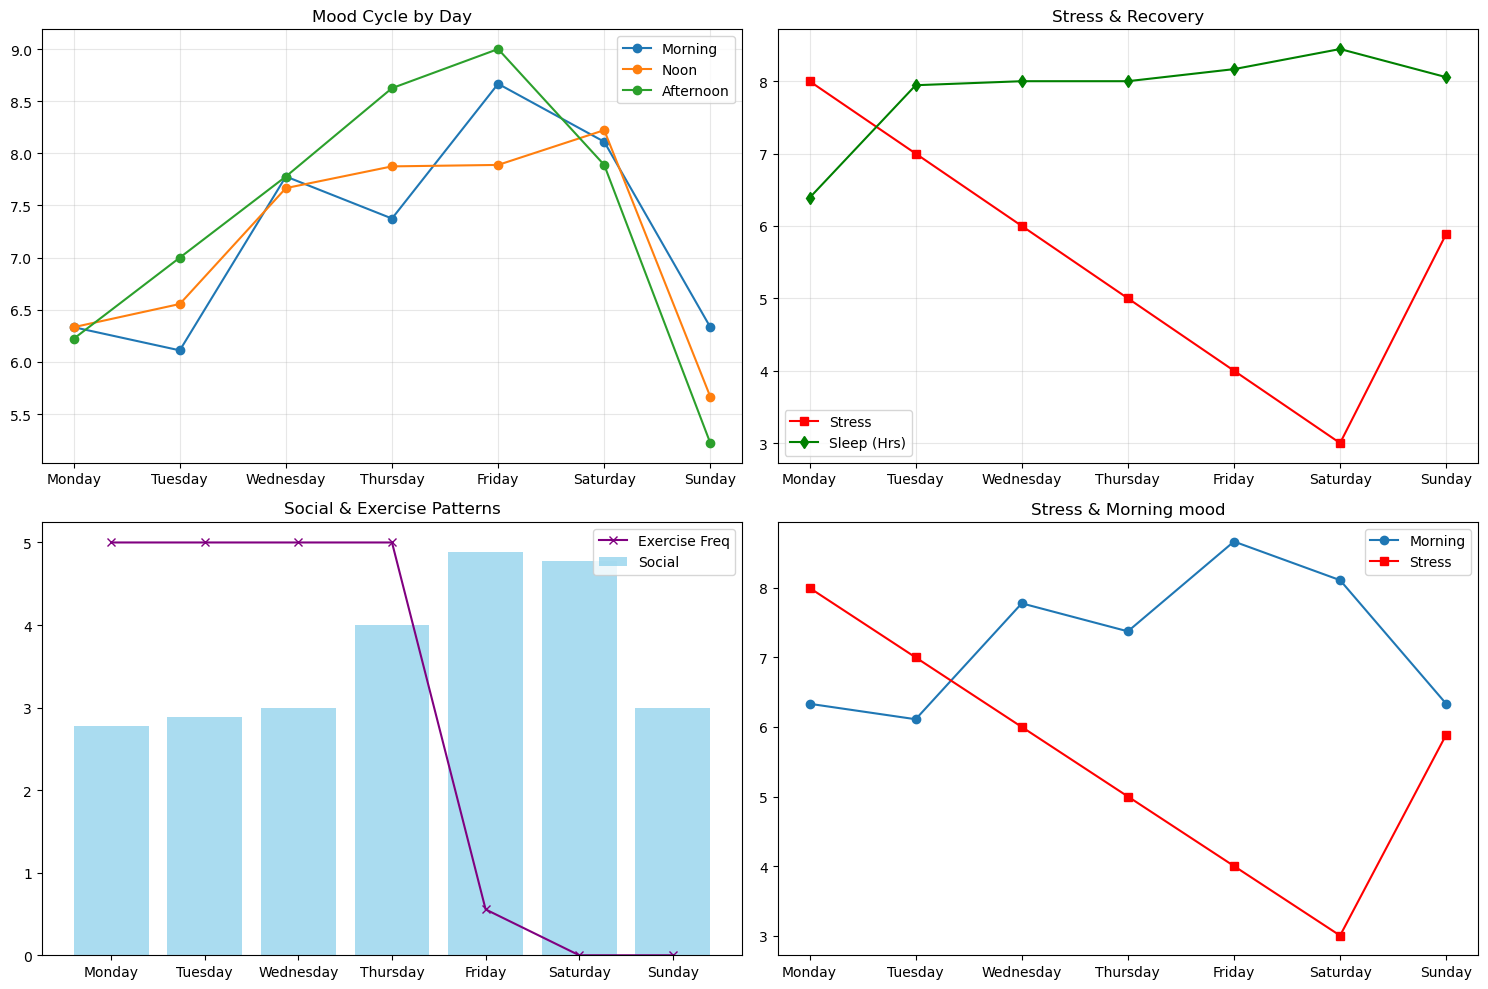

In [66]:
#VISUALIZATION

#extract Day of Week and set order
df['Day_of_Week'] = df['Date'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

#grroup all metrics
weekly_summary = df.groupby('Day_of_Week')[['Mood_Morning', 'Mood_Noon', 'Mood_Afternoon', 
                                            'Sleep', 'Stress', 'Exercise', 'Social']].mean().reindex(day_order)

plt.figure(figsize=(15, 10))

#Panel 1:mood Trends
plt.subplot(2, 2, 1)
plt.plot(weekly_summary.index, weekly_summary['Mood_Morning'], marker='o', label='Morning')
plt.plot(weekly_summary.index, weekly_summary['Mood_Noon'], marker='o', label='Noon')
plt.plot(weekly_summary.index, weekly_summary['Mood_Afternoon'], marker='o', label='Afternoon')
plt.title('Mood Cycle by Day')
plt.legend()
plt.grid(alpha=0.3)

#Panel 2: Stress vs. Sleep
plt.subplot(2, 2, 2)
plt.plot(weekly_summary.index, weekly_summary['Stress'], marker='s', color='red', label='Stress')
plt.plot(weekly_summary.index, weekly_summary['Sleep'], marker='d', color='green', label='Sleep (Hrs)')
plt.title('Stress & Recovery')
plt.legend()
plt.grid(alpha=0.3)

#Panel 3: Lifestyle Factors
plt.subplot(2, 2, 3)
plt.bar(weekly_summary.index, weekly_summary['Social'], color='skyblue', alpha=0.7, label='Social')
plt.plot(weekly_summary.index, weekly_summary['Exercise'] * 5, marker='x', color='purple', label='Exercise Freq')
plt.title('Social & Exercise Patterns')
plt.legend()

#Panel 4: Morning Mood vs Stress
plt.subplot(2, 2, 4)
plt.plot(weekly_summary.index, weekly_summary['Mood_Morning'], marker='o', label='Morning')
plt.plot(weekly_summary.index, weekly_summary['Stress'], marker='s', color='red', label='Stress')
plt.title('Stress & Morning mood')
plt.legend()

plt.tight_layout()
plt.show()

In [67]:
#ASSOCIATION ANALYSIS

N = len(df)
df['High_Social'] = df['Social'] >= 4
df['Exercised'] = df['Exercise'] == 1

# 1. SUPPORT: P(Exercised AND High_Social)
# How often do both occur together?
count_both = len(df[df['Exercised'] & df['High_Social']])
support = count_both / N

# 2. CONFIDENCE: P(High_Social | Exercised)
#If I exercise, what is the probability I am also social?
count_exercise = len(df[df['Exercised']])
confidence = count_both / count_exercise if count_exercise > 0 else 0

# 3. LIFT: Confidence / P(High_Social)
#Is exercising actually linked to being social, or is it just random?
prob_high_social = len(df[df['High_Social']]) / N
lift = confidence / prob_high_social if prob_high_social > 0 else 0

print(f"Association Rule: ['Exercised'] => ['High_Social']")
print(f"Support:    {support:.4f}")
print(f"Confidence: {confidence:.2f}")
print(f"Lift:       {lift:.2f}")

Association Rule: ['Exercised'] => ['High_Social']
Support:    0.1452
Confidence: 0.25
Lift:       0.60


In [68]:
#RECOMENDER SYSTEM

#Build Item Profiles (Average Day of Week behavior)
# We group by day to get the "representative profile" for each day type
day_profiles = df.groupby('Day_of_Week')[features].mean()

#Normalization (Min-Max Scaling)
#This squashes all features into a 0-1 range so Sleep doesn't overpower Exercise
scaler = MinMaxScaler()
day_profiles_scaled = pd.DataFrame(
    scaler.fit_transform(day_profiles), 
    index=day_profiles.index, 
    columns=features
)

# Build User Profile (Your 'Ideal' habits)
# We find days the user "liked" (Mood >= 8) and average their characteristics
ideal_days_data = df[df['Mood_Avg'] >= 8][features]
user_profile_raw = ideal_days_data.mean().to_frame().T 

#Transform the user profile (using to_frame().T avoids the Feature Names warning)
user_profile_scaled = scaler.transform(user_profile_raw)

#Compute Similarity: cosine_similarity
#Measuring how close each typical day is to your "High Mood" state
similarities = cosine_similarity(user_profile_scaled, day_profiles_scaled).flatten()

recommendation_table = pd.DataFrame({
    'Day of Week': day_profiles.index,
    'Similarity_to_Ideal': similarities
}).sort_values(by='Similarity_to_Ideal', ascending=False)

print("ecommendations")
print(recommendation_table.to_string(index=False))

#Identify gaps for recommendation
ideal_stats = ideal_days_data.mean()
worst_day = recommendation_table.iloc[-1]['Day of Week']

print(f"\nRecommendation: To improve {worst_day}, match your 'Ideal Profile':")
print(ideal_stats)

ecommendations
Day of Week  Similarity_to_Ideal
     Friday             0.966868
   Saturday             0.933797
   Thursday             0.884777
     Sunday             0.730106
  Wednesday             0.725996
    Tuesday             0.677168
     Monday             0.346796

Recommendation: To improve Monday, match your 'Ideal Profile':
Sleep       8.195652
Stress      4.173913
Exercise    0.391304
Social      4.478261
dtype: float64


In [70]:
#OUTLIERS

#1. Initialize and Fit the Model
model = IsolationForest(contamination=0.05, random_state=42)
df['Outlier_Score'] = model.fit_predict(df[['Mood_Morning', 'Stress', 'Sleep']])

#2. Filter the DataFrame to show only the "unusual" days (-1)
#We include Day_of_Week to see if there is a pattern in when these happen
outlier_days = df[df['Outlier_Score'] == -1]

#3. Print the results
print("--- Unusual Days Detected ---")
print(outlier_days[['Date', 'Day_of_Week', 'Mood_Morning', 'Sleep', 'Stress']])

--- Unusual Days Detected ---
         Date Day_of_Week  Mood_Morning  Sleep  Stress
2  2025-09-28      Sunday             6    8.5       6
10 2025-10-06      Monday             6    6.0       8
11 2025-10-07     Tuesday             5    7.5       7
24 2025-10-20      Monday             6    6.0       8
